In [7]:
import geopandas as gpd
import ipympl
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
shapefile = gpd.read_file("/home/simenallum/catkin_ws/src/msc_thesis/water_segmentation/data/trondheim_water/trondheim_water.shp")
print(shapefile)

   FID                                           geometry
0    0  POLYGON ((10.00400 63.49079, 10.00414 63.49079...


In [3]:
import osmnx as ox
from shapely.geometry import Point, Polygon

# Define the center point and radius of the bounding box
center_point = (63.439244, 10.400889) # Lat, Long
radius = 100 # in meters

# Calculate the bounding box using the center point and radius
bounds = ox.utils_geo.bbox_from_point(center_point, dist=radius)
north, south, east, west = bounds

# Create a polygon geometry from the bounding box coordinates
bbox_polygon = Polygon([(west, north), (east, north), (east, south), (west, south)])

large_scale_bbx_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:4326")

large_scale_bbx_gdf


,geometry
0,"POLYGON ((10.39888 63.44014, 10.40290 63.44014..."


In [4]:
import geopandas as gpd
from shapely.ops import unary_union

# read the first GeoDataFrame with a single polygon
df1 = large_scale_bbx_gdf

# read the second GeoDataFrame with multiple polygons
df2 = shapefile

# extract the polygon from df1 (assuming it's the only one)
polygon1 = df1.geometry[0]

# create a spatial index for df2
sindex = df2.sindex

# find the polygons in df2 that intersect with polygon1
possible_matches_index = list(sindex.intersection(polygon1.bounds))
possible_matches = df2.iloc[possible_matches_index].loc[df2.intersects(polygon1)]

# compute the intersection between polygon1 and all polygons in possible_matches
intersections = possible_matches.intersection(polygon1)

# compute the union of the resulting polygons
new_polygon = unary_union(intersections)

# create a new GeoDataFrame with the new polygon
large_scale_map_gdf = gpd.GeoDataFrame({'geometry': [new_polygon]}, crs=df1.crs)

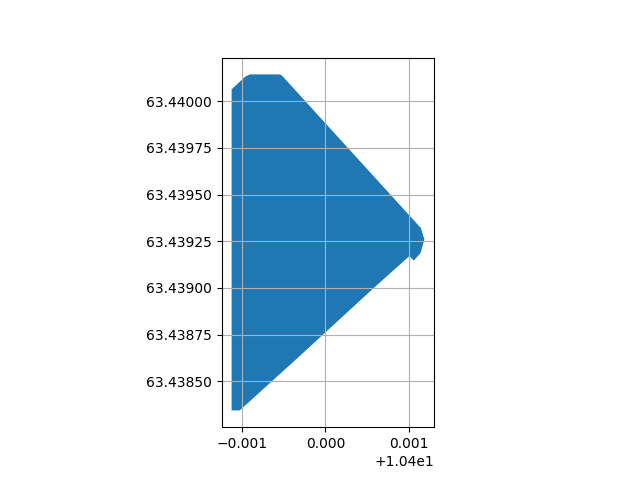

In [8]:
large_scale_map_gdf.plot()
plt.grid()

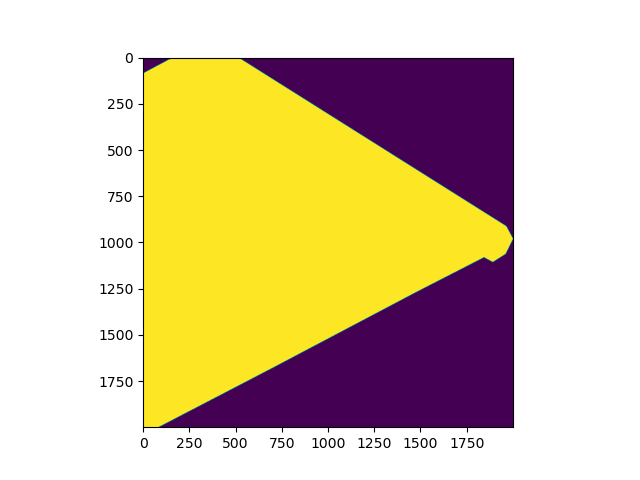

In [268]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask

# Load your GeoPandas DataFrame containing the polygon
gdf = large_scale_map_gdf

# Extract the polygon from the GeoPandas DataFrame
polygon = gdf.geometry[0]

# Define the resolution of the mask (in this example, 100x100 pixels)
mask_width = 2000
mask_height = 2000

# Define the bounding box of the mask (in the same CRS as the polygon)
bounds = polygon.bounds
xmin, ymin, xmax, ymax = bounds
xres = (xmax - xmin) / mask_width
yres = (ymax - ymin) / mask_height

# Create an empty numpy array to store the mask
mask = np.zeros((mask_height, mask_width), dtype=np.uint8)

# Convert the polygon to a binary mask
geo = geometry_mask(geometries=[polygon],
              out_shape=mask.shape,
              transform=rasterio.Affine(xres, 0.0, xmin,
                                        0.0, -yres, ymax),
              invert=True,
              all_touched=True,
              )

plt.figure()
plt.imshow(geo)
plt.show()

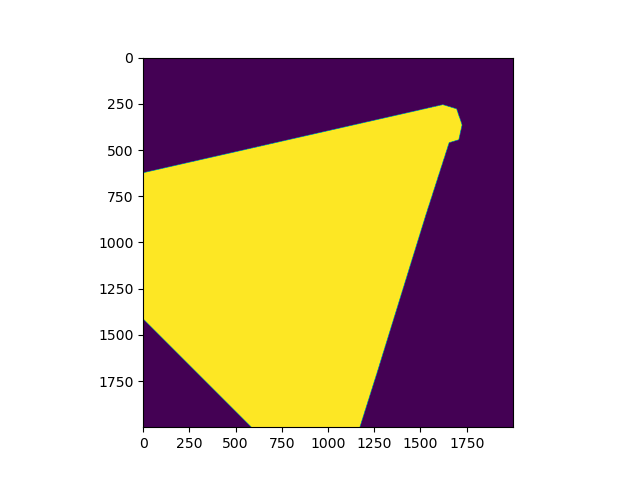

In [285]:
import cv2
import numpy as np

# Load the image as a NumPy array
img = geo.astype('uint8')

# Define the rotation angle in degrees
angle = 45

# Get the image dimensions
width, height = img.shape[:2]

# Calculate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)

# Apply the rotation to the image
rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height))

# Display the rotated image
plt.figure()
plt.imshow(rotated_img)
plt.show()


461
820
(922, 1640)


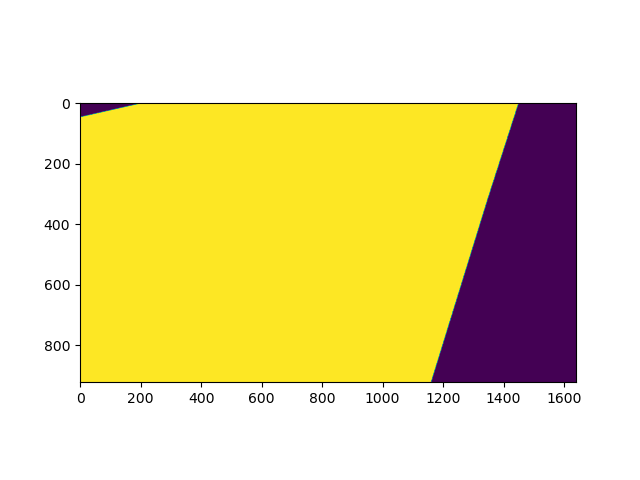

In [286]:
import cv2
import numpy as np

# Load the image as a NumPy array
img = rotated_img

# Get the image dimensions
width, height = img.shape[:2]

# Define the number of pixels to take on each side of the center in the x direction
n_x = int(82 / (100/2000) / 2)

# Define the number of pixels to take in the height direction
n_y = int((82*(9/16)) / (100/2000) / 2)
print(n_y)
print(n_x)

# Calculate the x and y coordinates of the center of the image
center_x = width // 2
center_y = height // 2

# Calculate the coordinates of the top-left corner of the new image
start_x = center_x - n_x
start_y = center_y - n_y

# Calculate the coordinates of the bottom-right corner of the new image
end_x = center_x + n_x
end_y = center_y + n_y

# Get the section of the image as a new image
new_img = img[start_y:end_y, start_x:end_x]
print(new_img.shape)

# Display the new image
plt.figure()
plt.imshow(new_img)
plt.show()


(720, 1280)


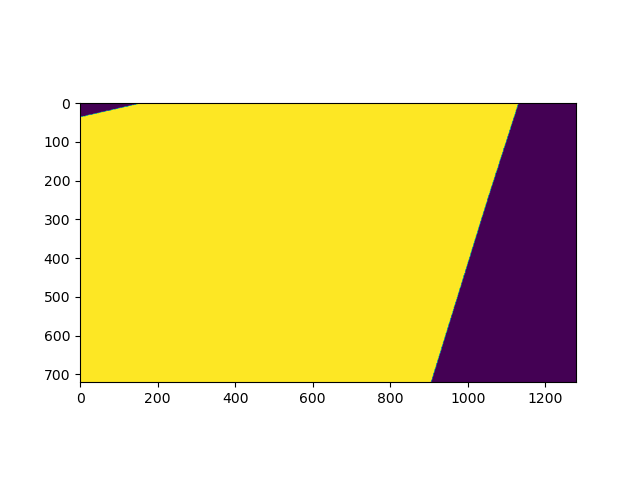

In [287]:
from skimage import io, transform
import numpy as np

# Load the binary image
binary_image = new_img.astype('uint8')

# Define the new resolution
new_resolution = (1280, 720)

# Resize the image to the new resolution
resized_image = cv2.resize(binary_image, new_resolution, interpolation=cv2.INTER_CUBIC)

# Convert the image to integer type
resized_image = resized_image.astype('uint8')

# Save the resized image
print(resized_image.shape)
plt.figure()
plt.imshow(resized_image)
plt.show()
